# Item-Based Collaborative Filtering

In [2]:
!pip install -q -U scikit-surprise
!pip install -q numpy==1.26.4

In [3]:
import pandas as pd
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size

# Seeting the seed for reprodcuibility

In [5]:
# we set a random seed here to make the results in this notebook reproducible
import random
import numpy as np

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# Reading data

In [7]:
df_train = pd.read_csv('../Data/train_preprocessed_binned.csv')
df_train.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment,has_look,has_smell,has_taste,has_feel,mentioned_aspects,score_bin
0,21002,Damian,2006-11-25,"drank on-tap city steam brewery, hartford, ct ...",4.5,4.5,4.5,5.0,5.0,4.65,positive,True,True,True,True,"look, smell, taste, feel","[4.5, 5.0)"
1,1371,hustlesworth,2007-09-27,a- clear golden yellow 3/4in foamy white head ...,2.5,2.0,2.5,2.5,4.0,2.68,neutral,True,True,True,True,"look, smell, taste, feel","[2.5, 3.0)"
2,1937,TheManiacalOne,2007-07-02,on-tap 6/30/07 racebook brewpub @ mohegan sun ...,3.0,3.0,3.0,3.0,3.0,3.00,neutral,True,True,True,True,"look, smell, taste, feel","[3.0, 3.5)"
3,1075,woodychandler,2011-08-18,purchased shiner family reunion 6-pack visitin...,3.0,3.0,1.0,2.0,2.5,2.00,negative,True,True,True,True,"look, smell, taste, feel","[2.0, 2.5)"
4,3982,brewandbbq,2012-10-30,"12oz bottle, batch #5. pours chestnut brown ru...",3.5,4.0,4.0,4.0,4.0,3.97,neutral,True,True,True,True,"look, smell, taste, feel","[3.5, 4.0)"


In [8]:
df_test = pd.read_csv('../Data/test_preprocessed_binned.csv')
df_test.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment,has_look,has_smell,has_taste,has_feel,mentioned_aspects,score_bin
0,55099,Transatlantic,2010-10-07,poured on-tap local english pub. - nice amber ...,4.5,2.50,3.0,3.0,3.0,2.97,neutral,True,True,True,True,"look, smell, taste, feel","[2.5, 3.0)"
1,74579,DarthKostrizer,2011-11-23,look: dark brown color quite black 1 inch head...,4.5,2.50,2.0,4.5,3.0,2.72,neutral,True,True,True,True,"look, smell, taste, feel","[2.5, 3.0)"
2,91220,Maho,2013-08-11,- poured 12 oz tulip glass. pours copper/amber...,3.5,3.25,3.5,3.0,3.5,3.39,neutral,True,True,True,True,"look, smell, taste, feel","[3.0, 3.5)"
3,13896,schwansmantr,2015-10-12,i’ve trying several different oktoberfests lat...,5.0,5.00,1.0,1.0,1.0,2.20,neutral,True,True,True,True,"look, smell, taste, feel","[2.0, 2.5)"
4,45308,Treath,2013-11-02,first time tasting beer. 12oz poured glass mug...,2.0,2.00,2.0,2.0,2.0,2.00,negative,True,True,True,True,"look, smell, taste, feel","[2.0, 2.5)"


In [9]:
df_train = df_train[['beer_id', 'username', 'score']]
df_train.head()

,beer_id,username,score
0,21002,Damian,4.65
1,1371,hustlesworth,2.68
2,1937,TheManiacalOne,3.00
3,1075,woodychandler,2.00
4,3982,brewandbbq,3.97


In [10]:
df_test = df_test[['beer_id', 'username', 'score']]
df_test.head()

,beer_id,username,score
0,55099,Transatlantic,2.97
1,74579,DarthKostrizer,2.72
2,91220,Maho,3.39
3,13896,schwansmantr,2.20
4,45308,Treath,2.00


# Training 

In [12]:
from surprise import Reader, Dataset, KNNBasic
reader = Reader(rating_scale=(0, 5))

# Convert df_train into Surprise's internal training format
data = Dataset.load_from_df(df_train[['username', 'beer_id', 'score']], reader)
trainset = data.build_full_trainset()

# Convert df_test into Surprise's expected testset format
testset = list(df_test[['username', 'beer_id', 'score']].itertuples(index=False, name=None))

In [13]:
sim_options = {'name': 'cosine', 'user_based': False, 'min_support': 1}

In [14]:
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [15]:
from surprise import KNNWithMeans
algo2 = KNNWithMeans(sim_options=sim_options)
algo2.fit(trainset)
predictions2 = algo2.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [16]:
from surprise import KNNWithZScore
algo3 = KNNWithZScore(sim_options=sim_options)
algo3.fit(trainset)
predictions3 = algo3.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [17]:
from surprise import KNNBaseline
algo_baseline = KNNBaseline(sim_options=sim_options)
algo_baseline.fit(trainset)
predictions_baseline = algo_baseline.test(testset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


# Evaluation

In [19]:
metrics = ['RMSE', 'MAE', 'MSE']

In [20]:
from surprise.accuracy import mse, rmse, mae
# Compute MSE, RMSE and MAE on the test set predictions
def evaluate_recommender(predictions):
    mse_score = mse(predictions, verbose=False)
    rmse_score = rmse(predictions, verbose=False)
    mae_score = mae(predictions, verbose=False)
    return rmse_score, mae_score, mse_score

In [21]:
import matplotlib.pyplot as plt

def plot_predictions(predictions, metrics, model_name=""):
    rmse_score, mse_score, mae_score = predictions
    fig, ax = plt.subplots(figsize=(12, 6))  

    # Add title with model name
    ax.set_title(f"Evaluation Metrics for {model_name}", fontsize=14)

    ax.set_ylabel("Score")
    ax.set_xlabel("Metric")
    ax.set_ylim(0, 5)
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics)

    # Draw bar chart
    ax.bar(range(len(metrics)), [rmse_score, mae_score, mse_score], color=['blue', 'orange', 'green'])

    # Add value labels
    for i, value in enumerate([rmse_score, mse_score, mae_score]):
        ax.text(i - 0.1, value + 0.02, str(round(value, 2)), color='black', fontweight='bold')

    # Add horizontal gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

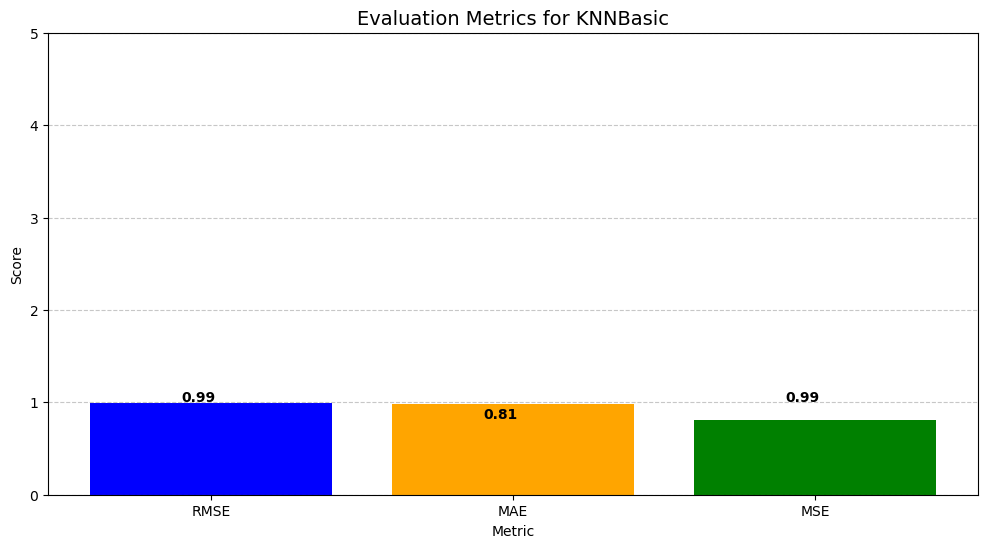

In [22]:
# Plot the metrics rmse, mse and mae
results = evaluate_recommender(predictions)
plot_predictions(results, metrics, model_name= "KNNBasic")

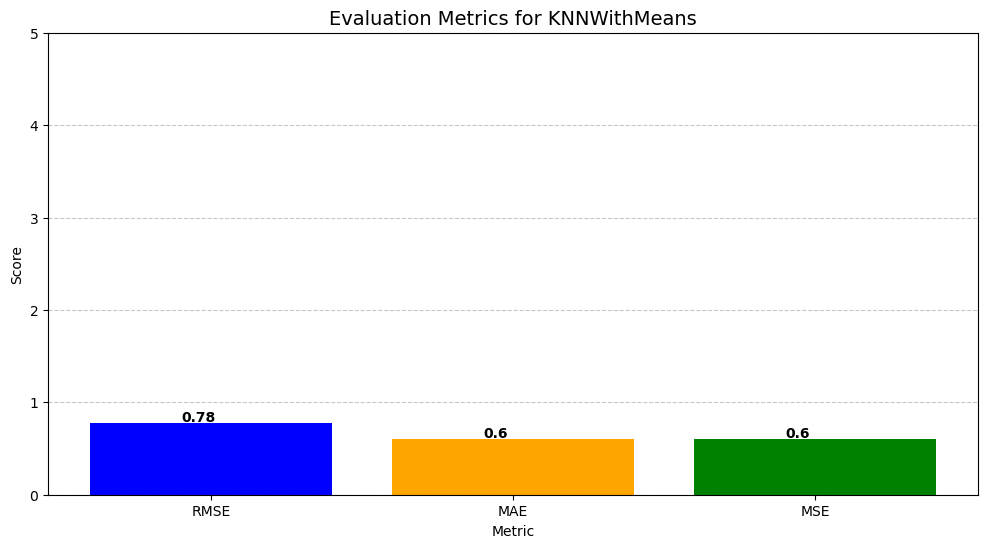

In [23]:
results2 = evaluate_recommender(predictions2)
plot_predictions(results2, metrics, model_name= "KNNWithMeans")

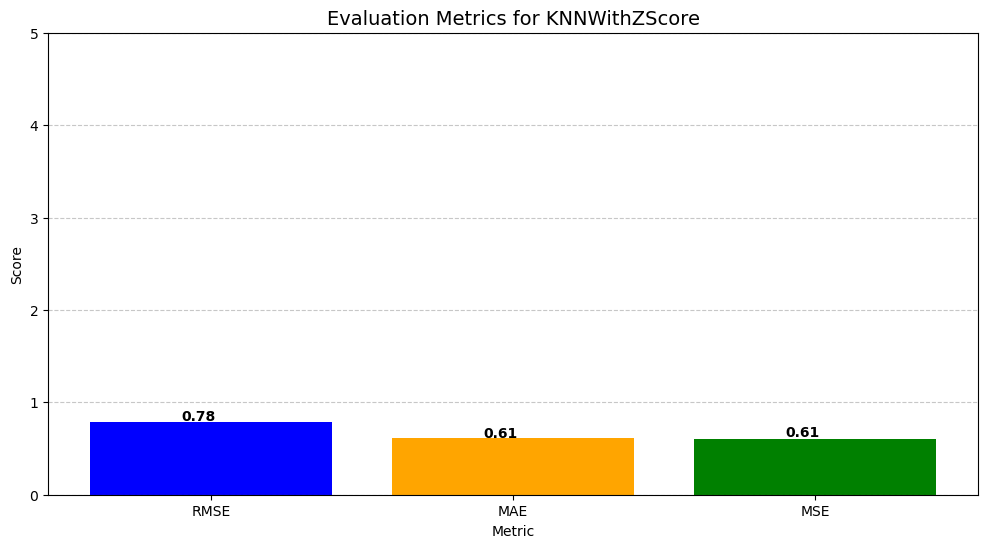

In [24]:
results3 = evaluate_recommender(predictions3)
plot_predictions(results3, metrics, model_name= "KNNWithZScore")

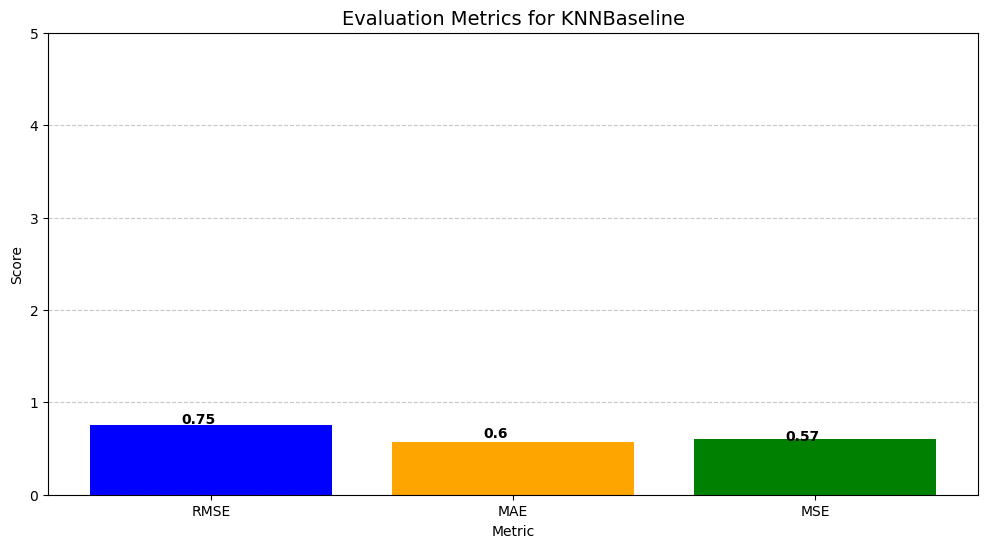

In [25]:
results_baseline = evaluate_recommender(predictions_baseline)
plot_predictions(results_baseline, metrics, model_name= "KNNBaseline")

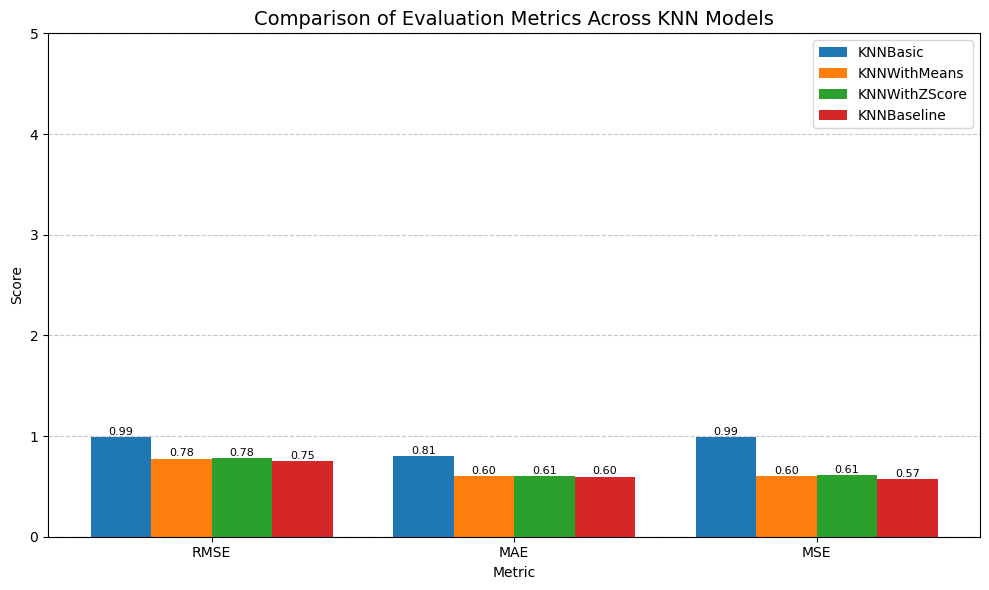

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define metric labels in correct order
metrics = ['RMSE', 'MAE', 'MSE']

# Evaluate all model predictions using updated order
scores_basic = evaluate_recommender(predictions)               # KNNBasic
scores_with_means = evaluate_recommender(predictions2)         # KNNWithMeans
scores_zscore = evaluate_recommender(predictions3)             # KNNWithZScore
scores_baseline = evaluate_recommender(predictions_baseline)   # KNNBaseline

model_names = ['KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']
all_scores = [scores_basic, scores_with_means, scores_zscore, scores_baseline]

# Convert to numpy array for plotting
score_matrix = np.array(all_scores)  # shape: (4 models, 3 metrics)
bar_width = 0.2
x = np.arange(len(metrics))

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
for i, scores in enumerate(score_matrix):
    ax.bar(x + i * bar_width, scores, width=bar_width, label=model_names[i])

# Step 5: Customize chart
ax.set_title("Comparison of Evaluation Metrics Across KNN Models", fontsize=14)
ax.set_xlabel("Metric")
ax.set_ylabel("Score")
ax.set_xticks(x + 1.5 * bar_width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 5)
ax.legend()

# Add value labels
for i in range(len(model_names)):
    for j in range(len(metrics)):
        value = score_matrix[i][j]
        ax.text(x[j] + i * bar_width, value + 0.02, f'{value:.2f}', ha='center', fontsize=8)

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Evaluation Summary (Without Sentiment Score)

### Item-Based
- **Best Model:** KNNBaseline  
- **Metrics:** RMSE = 0.75, MAE = 0.60, MSE = 0.57